# Attention: Illustrated Attention
- based on https://towardsdatascience.com/attn-illustrated-attention-5ec4ad276ee3
![](https://miro.medium.com/max/1400/1*qN2Pj5J4VqAFf7dsA2dHpA.png)

For decades, Statistical Machine Translation has been the dominant translation model, until the birth of **Neural Machine Translation (NMT)**. NMT is an emerging approach to machine translation that attempts to build and train a single, large neural network that reads an input text and outputs a translation

The pioneers of NMT are proposals from *Kalchbrenner and Blunsom (2013)*, *Sutskever et. al (2014) and Cho. et. al (2014b)*, where the more familiar framework is the sequence-to-sequence (seq2seq) learning from Sutskever et. al. This article will be based on the seq2seq framework and how attention can be built on it.

![](https://miro.medium.com/max/1400/1*hG-VIciA7fmGYcSKD9YhZg.png)

In seq2seq, the idea is to have two recurrent neural networks (RNNs) with an **encoder-decoder architecture**: *read the input words one by one to obtain a vector representation of a fixed dimensionality (encoder), and, conditioned on these inputs, extract the output words one by one using another RNN (decoder)*. 

![](https://miro.medium.com/max/1400/1*erEV0fHM233twhYPhw3gvg.png)
Fig. 0.2: seq2seq with an input sequence of length 64

The trouble with seq2seq is that the only information that the decoder receives from the encoder is the last encoder hidden state (the 2 tiny red nodes in Fig. 0.1), a vector representation which is like a numerical summary of an input sequence. So, for a long input text (Fig. 0.2), we unreasonably expect the decoder to use just this one vector representation (hoping that it ‘sufficiently summarises the input sequence’) to output a translation. This might lead to catastrophic forgetting. This paragraph has 100 words. Can you translate this paragraph to another language you know, right after this question mark?

If we can’t, then we shouldn’t be so cruel to the decoder. How about instead of just one vector representation, let’s give the decoder a vector representation from every encoder time step so that it can make well-informed translations? Enter attention.

![](https://miro.medium.com/max/1400/1*xCQbNIXsHxaEU0MZXDlAHQ.png)
Fig 0.3: Adding an attention as an interface between encoder and decoder. Here, the first decoder time step is getting ready to receive information from encoder before giving the first translated word.

**Definition: alignment**
Alignment means matching segments of original text with their corresponding segments of the translation.

![](https://miro.medium.com/max/1400/1*zi6xetJ8oBmBvh49b0soRw@2x.png)
Fig. 0.3: Alignment for the French word ‘la’ is distributed across the input sequence but mainly on these 4 words: ‘the’, ‘European’, ‘Economic’ and ‘Area’. Darker purple indicates better attention scores (Image source)

There are 2 types of attention. The type of attention that uses all the encoder hidden states is also known as **global attention**. In contrast, **local attention** uses only a subset of the encoder hidden states. As the scope of this article is global attention, any references made to “attention” in this article are taken to mean “global attention.”

## Contents
1. Attention: Overview
2. Attention: Examples
3. Summary

### Attention: Overview
Before we look at how attention is used, allow me to share with you the intuition behind a translation task using the seq2seq model.

#### Intuition: seq2seq
A translator reads the German text from start till the end. Once done, he starts translating to English word by word. It is possible that if the sentence is extremely long, he might have forgotten what he has read in the earlier parts of the text.

So that’s a simple seq2seq model. The step-by-step calculation for the attention layer I am about to go through is a seq2seq+attention model. Here’s a quick intuition on this model.

#### Intuition: seq2seq + attention

A translator reads the German text while writing down the keywords from the start till the end, after which he starts translating to English. While translating each German word, he makes use of the keywords he has written down.

Attention places different focus on different words by assigning each word with a score. Then, using the softmaxed scores, we aggregate the encoder hidden states using a weighted sum of the encoder hidden states, to get the context vector. The implementations of an attention layer can be broken down into 4 steps.

#### Step 0: Prepare hidden states.

Let’s first prepare all the available encoder hidden states (green) and the first decoder hidden state (red). In our example, we have 4 encoder hidden states and the current decoder hidden state. (Note: the last consolidated encoder hidden state is fed as input to the first time step of the decoder. The output of this first time step of the decoder is called the first decoder hidden state, as seen below.)

![](https://miro.medium.com/max/1400/1*qzWqd8mpvSdM7zZE330E3w.gif)
Fig. 1.0: Getting ready to pay attention

#### Step 1: Obtain a score for every encoder hidden state.

A score (scalar) is obtained by a score function (also known as alignment score function) or alignment model. In this example, the score function is a dot product between the decoder and encoder hidden states.

![](https://miro.medium.com/max/1400/1*xoeI4Gz1nQFvntQA3jRq5w.gif)
Fig. 1.1: Get the scores


decoder_hidden = [10, 5, 10]
encoder_hidden  score
---------------------
     [0, 1, 1]     15 (= 10×0 + 5×1 + 10×1, the dot product)
     [5, 0, 1]     60
     [1, 1, 0]     15
     [0, 5, 1]     35

In the above example, we obtain a high attention score of 60 for the encoder hidden state [5, 0, 1]. This means that the next word (next output by the decoder) is going to be heavily influenced by this encoder hidden state.

#### Step 2: Run all the scores through a softmax layer.

We put the scores to a softmax layer so that the softmaxed scores (scalar) add up to 1. These softmaxed scores represent the attention distribution [3, 10].
![](https://miro.medium.com/max/1400/1*4Zk-5y_XZdD3x7xk6JytGA.gif)
Fig. 1.2: Get the softmaxed scores

encoder_hidden  score  score^
-----------------------------
     [0, 1, 1]     15       0
     [5, 0, 1]     60       1
     [1, 1, 0]     15       0
     [0, 5, 1]     35       0


Notice that based on the softmaxed score score^, the distribution of attention is only placed on [5, 0, 1] as expected. In reality, these numbers are not binary but a floating point between 0 and 1.

#### Step 3: Multiply each encoder hidden state by its softmaxed score.

By multiplying each encoder hidden state with its softmaxed score (scalar), we obtain the alignment vector [2] or the annotation vector [1]. This is exactly the mechanism where alignment takes place.

![](https://miro.medium.com/max/1400/1*To0B46mMA8sHuHqJMwnQbg.gif)
Fig. 1.3: Get the alignment vectors

encoder  score  score^  alignment
---------------------------------
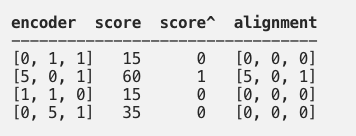

Here we see that the alignment for all encoder hidden states except [5, 0, 1] are reduced to 0 due to low attention scores. This means we can expect that the first translated word should match the input word with the [5, 0, 1] embedding.


#### Step 4: Sum up the alignment vectors.

The alignment vectors are summed up to produce the context vector [1, 2]. A context vector is an aggregated information of the alignment vectors from the previous step.

![](https://miro.medium.com/max/1400/1*yba9dZaE9bEYtDxLqX1tow.gif)
Fig. 1.4: Get the context vector

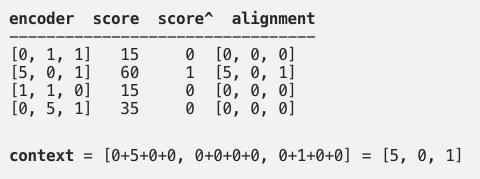

##### Step 5: Feed the context vector into the decoder.

The manner this is done depends on the architecture design. Later we will see in the examples in Sections 2a, 2b and 2c how the architectures make use of the context vector for the decoder.
![](https://miro.medium.com/max/1400/1*2dLzmSops3jTvTR1wzRX0w.gif)
Fig. 1.5: Feed the context vector to decoder

That’s about it! Here’s the entire animation:

![](https://miro.medium.com/max/1400/1*wBHsGZ-BdmTKS7b-BtkqFQ.gif)

#### Training and inference

During inference, the input to each decoder time step t is the **predicted output** from decoder time step t-1.
During training, the input to each decoder time step t is our **ground truth output** from decoder time step t-1.

#### Intuition: How does attention actually work?

Answer: Backpropagation, surprise surprise. Backpropagation will do whatever it takes to ensure that the outputs will be close to the ground truth. This is done by altering the weights in the RNNs and in the score function, if any. These weights will affect the encoder hidden states and decoder hidden states, which in turn affect the attention scores.

###  Attention: Examples

We have seen the both the seq2seq and the seq2seq+attention architectures in the previous section. In the next sub-sections, let’s examine 3 more seq2seq-based architectures for NMT that implement attention. For completeness, I have also appended their Bilingual Evaluation Understudy (BLEU) scores — a standard metric for evaluating a generated sentence to a reference sentence.

#### 2a. Bahdanau et. al (2015)

This implementation of attention is one of the founding attention fathers. The authors use the word ‘align’ in the title of the paper “Neural Machine Translation by Learning to Jointly Align and Translate” to mean adjusting the weights that are directly responsible for the score, while training the model. The following are things to take note about the architecture:

1. The encoder is a bidirectional (forward+backward) gated recurrent unit (BiGRU). The decoder is a GRU whose initial hidden state is a vector modified from the last hidden state from the backward encoder GRU (not shown in the diagram below).

2. The score function in the attention layer is the **additive/concat**.

3. The input to the next decoder step is the concatenation between the generated word from the previous decoder time step (pink) and context vector from the current time step (dark green).

![](https://miro.medium.com/max/1400/1*IoNs3pdgl57_HqRXufZ0lA.png)
Fig. 2a: NMT from Bahdanau et. al. Encoder is a BiGRU, decoder is a GRU.

The authors achieved a BLEU score of 26.75 on the WMT’14 English-to-French dataset.

#### Intuition: seq2seq with bidirectional encoder + attention

Translator A reads the German text while writing down the keywords. Translator B (who takes on a senior role because he has an extra ability to translate a sentence from reading it backwards) reads the same German text from the last word to the first, while jotting down the keywords. These two regularly discuss about every word they read thus far. Once done reading this German text, Translator B is then tasked to translate the German sentence to English word by word, based on the discussion and the consolidated keywords that the both of them have picked up.

Translator A is the forward RNN, Translator B is the backward RNN.

#### 2b. Luong et. al (2015)

The authors of Effective Approaches to Attention-based Neural Machine Translation have made it a point to simplify and generalise the architecture from Bahdanau et. al. Here’s how:

1. The encoder is a two-stacked long short-term memory (LSTM) network. The decoder also has the same architecture, whose initial hidden states are the last encoder hidden states.
2. The score functions they experimented were (i) additive/concat, (ii) dot product, (iii) location-based, and (iv) ‘general’.
3. The concatenation between output from current decoder time step, and context vector from the current time step are fed into a feed-forward neural network to give the final output (pink) of the current decoder time step.

![](https://miro.medium.com/max/1400/1*ICeT6bTWmzUaGQkpKWVnLQ.png)
Fig. 2b: NMT from Luong et. al. Encoder is a 2 layer LSTM, likewise for decoder.

On the WMT’15 English-to-German, the model achieved a BLEU score of 25.9.


#### 2c. Google’s Neural Machine Translation (GNMT)

Because most of us must have used Google Translate in one way or another, I feel that it is imperative to talk about Google’s NMT, which was implemented in 2016. GNMT is a combination of the previous 2 examples we have seen (heavily inspired by the first).
1. The encoder consists of a stack of 8 LSTMs, where the first is bidirectional (whose outputs are concatenated), and a residual connection exists between outputs from consecutive layers (starting from the 3rd layer). The decoder is a separate stack of 8 unidirectional LSTMs.

2. The score function used is the additive/concat.

3. Again, the input to the next decoder step is the concatenation between the output from the previous decoder time step (pink) and context vector from the current time step (dark green).

![](https://miro.medium.com/max/1400/1*Wp4HEnEwJkwoRwSDj9NOCQ.png)
Fig. 2c: Google’s NMT for Google Translate. Skip connections are denoted by curved arrows. *Note that the LSTM cells only show the hidden state and input; it does not show the cell state input.

The model achieves 38.95 BLEU on WMT’14 English-to-French, and 24.17 BLEU on WMT’14 English-to-German.


#### Intuition: GNMT — seq2seq with 8-stacked encoder (+bidirection+residual connections) + attention

8 translators sit in a column from bottom to top, starting with Translator A, B, …, H. Every translator reads the same German text. At every word, Translator A shares his/her findings with Translator B, who will improve it and share it with Translator C — repeat this process until we reach Translator H. Also, while reading the German text, Translator H writes down the relevant keywords based on what he knows and the information he has received.

Once everyone is done reading this English text, Translator A is told to translate the first word. First, he tries to recall, then he shares his answer with Translator B, who improves the answer and shares with Translator C — repeat this until we reach Translator H. Translator H then writes the first translation word, based on the keywords he wrote and the answers he got. Repeat this until we get the translation out.

## Summary

Here’s a quick summary of all the architectures that you have seen in this article:
- seq2seq
- seq2seq + attention
- seq2seq with bidirectional encoder + attention
- seq2seq with 2-stacked encoder + attention
- GNMT — seq2seq with 8-stacked encoder (+bidirection+residual connections) + attention

That’s it for now! In my next post, I will walk through with you the concept of self-attention and how it has been used in Google’s Transformer and Self-Attention Generative Adversarial Network (SAGAN). Keep an eye on this space!